In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datagovindia import DataGovIndia
from fuzzywuzzy import process

In [2]:
# To Sync The Data From Source
MY_API_KEY = "579b464db66ec23bdd000001973d3e2bd75e45f07473b608e00799e8"

datagovin = DataGovIndia(MY_API_KEY) # Specify API key if not set as an environment variable
# datagovin.sync_metadata(7000 , 20)

In [3]:
## IMPORTANT FUNCTIONS ##

# searching available dataframes by name
def search_datagov(search_term , columns = ['title', 'description']):
    search_data = datagovin.search(search_term)
    # search_data = datagovin.search(search_term , search_fields=columns)

    if len(search_data) > 0:

        search_titles = search_data['title']
        search_id = search_data['resource_id']

        # for res in zip(search_id , search_titles):
        #     print(res)

        return zip(search_id , search_titles)
    
    return "Not Found"

# getting a resource by ID, onvert it to csv as well
def datagov_data(r_id , save=False , filename = ''):
    data = datagovin.get_data(r_id)
    if save:
        data.to_csv(filename, index=False)

    print(data.columns)
    print(data.sample(5))
    return data

# show the non-intersecting columns of the 2 dfs, little outdated
def show_unmerged(df1 , df2 , col):
    # Perform an outer merge
    merged_outer = pd.merge(df1, df2, how='outer', on=col, indicator=True)

    # Filter out rows that were included in the inner merge
    deleted_rows = merged_outer[merged_outer['_merge'] == 'left_only']

    # Print the deleted rows
    print(deleted_rows)


# get population of the state (Census 2011)
def get_state_pop(state):
    india_df = pd.read_excel("2011-IndiaState.xlsx")
    
    # print(india_df.columns)

    states_total = india_df[['Name','TRU','TOT_P']][india_df['TRU'] == 'Total']
    states_total = states_total[['Name' , 'TOT_P']]
    
    best_match = process.extract(state, states_total['Name'], limit=1)[0][0]
    print("Matched Value:" , best_match)
    
    return states_total[states_total['Name'] == best_match]['TOT_P'].astype('int32').tolist()[0]


# rename all states so they are identical and ready for merging
def standardize_states(state_col):
    s_states = []

    # Iterate over each state name in the 'state' column
    for state in state_col:
        # Apply the standardize_states function to the state name and append the result to the list
        state_name = get_state_name(state)
        s_states.append(state_name)

    return s_states


# helper for standardize_states
def get_state_name(state):
    india_df = pd.read_csv("C:\\Users\\Ojasva Saxena\\Desktop\\Personal\\Maps\\Lucknow\\Unorganised_Workers_e-Shram_byStateFeb24.csv") # using these values of states as base
    
    # print(india_df.columns)

    states_total = india_df[['state_ut']]

    states_total['state_ut'] = states_total['state_ut'].str.upper()
 
    best_match = process.extract(state.upper(), states_total['state_ut'], limit=1)[0][0]
    print("Matched Value:" , best_match)
    
    return best_match


In [8]:
# SEARCH DATASETS

result = search_datagov("Agricultural Household")

for x in result:
    print(x)

('648a3e0a-6c16-4842-8539-4e2ca7d198eb', 'State/ UT-wise Estimated Number of Indebted Agricultural Households (in reply to Starred Question on 11-8-2017 (From: Ministry of Agriculture and Farmers Welfare)')
('f3093811-ddd7-4e03-8a4a-ce661fc8922b', 'State/ UT-wise Average Monthly Income and Average amount of outstanding loan per Agricultural Household during the agricultural year July 2012-June 2013 (From: Ministry of Agriculture and Farmers Welfare)')
('4a1a2083-ee08-44cd-8a7a-811f5aa07dda', 'States/ UT-wise Estimated Average monthly income Rs. per Agricultural Household for different during July 2012 to June 2013 (From: Ministry of Agriculture and Farmers Welfare)')
('41174634-e3ed-45c5-b213-6834ec62345f', 'State/Group of UT-wise Average Monthly Income (Rs.) per Agricultural Household during July 2012 - June 2013 (From: Ministry of Agriculture and Farmers Welfare)')
('96713046-dec1-4d4a-b309-0fc2ab6ded4b', 'State/ UT-wise Estimated Average Monthly Income per Agricultural Household dur

In [6]:
'''
('e20473ca-26e1-40c9-baae-f93f0b0a4f63', 'State/UT-wise Details of the Average Monthly Income per Agricultural Household (Considering paid out expenses only) during 2018-19')
('ad7e2039-ad61-499b-ba55-cfcfb4e084e1', 'State/ UT-wise Details of Average Monthly Income per Agricultural Household as per Situation Assessment Survey (SAS) Conducted from 2003 to 2013 (From: Ministry of Agriculture and Farmers Welfare)')
'''
data_2003_2013 = datagov_data("ad7e2039-ad61-499b-ba55-cfcfb4e084e1" , True , "Avg_Agri_Income_2003_2013.csv")

data_2018 = datagov_data("e20473ca-26e1-40c9-baae-f93f0b0a4f63" , True , "Avg_Agri_Income_2018.csv")

Index(['state__ut_name',
       'average_monthly_income_per_agricultural__farmers_household__rs_____sas_2003',
       'average_monthly_income_per_agricultural__farmers_household__rs_____sas_2013'],
      dtype='object')
      state__ut_name  \
7   Himachal Pradesh   
0     Andhra Pradesh   
16           Mizoram   
19            Punjab   
8    Jammu & Kashmir   

   average_monthly_income_per_agricultural__farmers_household__rs_____sas_2003  \
7                                                3309                            
0                                                1634                            
16                                               4862                            
19                                               4960                            
8                                                5488                            

    average_monthly_income_per_agricultural__farmers_household__rs_____sas_2013  
7                                                8777       

In [16]:
# DATA CLEANING FOR GOV DATA
df1 = pd.read_csv("./Avg_Agri_Income_2003_2013.csv")
df2 = pd.read_csv("./Avg_Agri_Income_2018.csv")

df = pd.merge(df1 , df2 , how="inner")

df['avg_income_2003'] = df['avg_income_2003'].astype('Float32')
df['avg_income_2013'] = df['avg_income_2013'].astype('Float32')
df['avg_income_2018'] = df['avg_income_2018'].astype('Float32')

df['change_2003_2013'] = ( (df['avg_income_2013'] - df['avg_income_2003']) / df['avg_income_2003'] ) * 100
df['change_2013_2018'] = ( (df['avg_income_2018'] - df['avg_income_2013']) / df['avg_income_2013'] ) * 100

df = df[:-1]

df['state'] = standardize_states(df['state'])

df

Matched Value: ANDHRA PRADESH
Matched Value: ARUNACHAL PRADESH
Matched Value: ASSAM
Matched Value: BIHAR
Matched Value: CHHATTISGARH
Matched Value: GUJARAT
Matched Value: HARYANA
Matched Value: HIMACHAL PRADESH
Matched Value: JAMMU AND KASHMIR
Matched Value: JHARKHAND
Matched Value: KARNATAKA
Matched Value: KERALA
Matched Value: MADHYA PRADESH
Matched Value: MAHARASHTRA
Matched Value: MANIPUR
Matched Value: MEGHALAYA
Matched Value: MIZORAM
Matched Value: NAGALAND
Matched Value: ODISHA
Matched Value: PUNJAB
Matched Value: RAJASTHAN
Matched Value: SIKKIM
Matched Value: TAMIL NADU
Matched Value: TELANGANA
Matched Value: TRIPURA
Matched Value: UTTARAKHAND
Matched Value: UTTAR PRADESH
Matched Value: WEST BENGAL


C:\Users\Ojasva Saxena\AppData\Local\Temp\ipykernel_36080\535679929.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_total['state_ut'] = states_total['state_ut'].str.upper()
C:\Users\Ojasva Saxena\AppData\Local\Temp\ipykernel_36080\535679929.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_total['state_ut'] = states_total['state_ut'].str.upper()
C:\Users\Ojasva Saxena\AppData\Local\Temp\ipykernel_36080\535679929.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,state,avg_income_2003,avg_income_2013,avg_income_2018,change_2003_2013,change_2013_2018
0,ANDHRA PRADESH,1634.0,5979.0,10480.0,265.911865,75.280151
1,ARUNACHAL PRADESH,7455.0,10869.0,19225.0,45.794765,76.879196
2,ASSAM,3161.0,6695.0,10675.0,111.800064,59.44735
3,BIHAR,1810.0,3558.0,7542.0,96.574585,111.973022
4,CHHATTISGARH,1618.0,5177.0,9677.0,219.962906,86.922928
5,GUJARAT,2684.0,7926.0,12631.0,195.305511,59.361595
6,HARYANA,2882.0,14434.0,22841.0,400.832764,58.244427
7,HIMACHAL PRADESH,3309.0,8777.0,12153.0,165.246292,38.464169
8,JAMMU AND KASHMIR,5488.0,12683.0,18918.0,131.104233,49.160294
9,JHARKHAND,2069.0,4721.0,4895.0,128.177872,3.68566


In [17]:

# Readying Geodata File

shp_path =  "C:\\Users\\Ojasva Saxena\\Desktop\\Personal\\Maps\\maps-master\\maps-master\\Survey-of-India-Index-Maps\\stateBoundary\\stateBoundary.shp"
map_gdf = gpd.read_file(shp_path)

map_gdf.columns = ['state' , 'geometry']

map_gdf['state'] = standardize_states(map_gdf['state'])

Matched Value: ANDAMAN AND NICOBAR ISLANDS
Matched Value: CHANDIGARH
Matched Value: DADRA AND NAGAR HAVELI AND DAMAN AND DIU
Matched Value: DADRA AND NAGAR HAVELI AND DAMAN AND DIU
Matched Value: DELHI
Matched Value: HARYANA
Matched Value: JHARKHAND
Matched Value: KARNATAKA
Matched Value: KERALA
Matched Value: LAKSHADWEEP
Matched Value: MADHYA PRADESH
Matched Value: MAHARASHTRA
Matched Value: ODISHA
Matched Value: PUDUCHERRY
Matched Value: TAMIL NADU
Matched Value: CHHATTISGARH
Matched Value: TELANGANA
Matched Value: ANDHRA PRADESH
Matched Value: PUDUCHERRY
Matched Value: GOA
Matched Value: JAMMU AND KASHMIR
Matched Value: HIMACHAL PRADESH
Matched Value: PUNJAB
Matched Value: RAJASTHAN
Matched Value: GUJARAT
Matched Value: UTTARAKHAND
Matched Value: UTTAR PRADESH
Matched Value: SIKKIM
Matched Value: ASSAM
Matched Value: ARUNACHAL PRADESH
Matched Value: NAGALAND
Matched Value: MANIPUR
Matched Value: MIZORAM
Matched Value: TRIPURA
Matched Value: MEGHALAYA
Matched Value: WEST BENGAL
Match

C:\Users\Ojasva Saxena\AppData\Local\Temp\ipykernel_36080\535679929.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_total['state_ut'] = states_total['state_ut'].str.upper()
C:\Users\Ojasva Saxena\AppData\Local\Temp\ipykernel_36080\535679929.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_total['state_ut'] = states_total['state_ut'].str.upper()
C:\Users\Ojasva Saxena\AppData\Local\Temp\ipykernel_36080\535679929.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [19]:
# MERGE MAP TO GOVT DF

map_data = pd.merge(map_gdf , df , how='left' , on="state")

<Figure size 640x480 with 0 Axes>

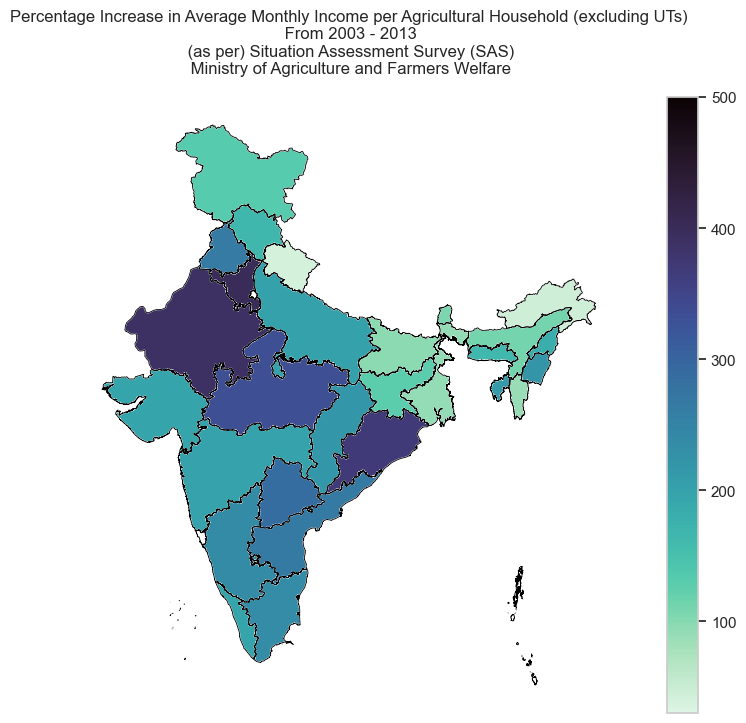

"\n('e20473ca-26e1-40c9-baae-f93f0b0a4f63', 'State/UT-wise Details of the Average Monthly Income per Agricultural Household (Considering paid out expenses only) during 2018-19')\n('ad7e2039-ad61-499b-ba55-cfcfb4e084e1', 'State/ UT-wise Details of Average Monthly Income per Agricultural Household as per Situation Assessment Survey (SAS) Conducted from 2003 to 2013 (From: Ministry of Agriculture and Farmers Welfare)')\n"

In [40]:
# PLOT MAP

'''
COLOURS:
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 
'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd',
'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2',
'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 
'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn',
'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 
'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot',
'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis',
'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 
'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 
'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 
'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 
'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 
'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 
'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 
'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 
'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r',
'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'
'''
'''
Set2 , Wistia , 
'''

# change_2003_2013	change_2013_2018

value_column = 'change_2003_2013'

sns.set(style="whitegrid")  # Set seaborn style
sns.despine()  # Remove spines

# Create a figure and axis object
ax = map_data.boundary.plot(edgecolor="black" , linewidth=0.6 , figsize=(12,8))
map_data.plot(ax=ax, column=value_column , legend="True" , cmap='mako_r' , vmin=30 , vmax=500) # Wistia

# for idx, row in map_data.iterrows():
# 	if row['change'] > 0:
# 	    change = "+" + str(round(row['change'] , 1))
# 	else:
# 	    change = "-" + str(round(row['change'] , 1))

# 	centroid = row.geometry.centroid
# 	ax.annotate(change, xy=(centroid.x, centroid.y), xytext=(0,0), textcoords="offset points", fontsize=9, color='darkred',fontfamily='serif')


# Set plot title and labels
ax.set_title("Percentage Increase in Average Monthly Income per Agricultural Household (excluding UTs)\n From 2003 - 2013\n (as per) Situation Assessment Survey (SAS)\n Ministry of Agriculture and Farmers Welfare")
plt.axis("off")

# Save the plot
plt.savefig('Change_Agri_Household_Income_2003_2013.png' , dpi=300 , bbox_inches='tight')
plt.show()

'''
('e20473ca-26e1-40c9-baae-f93f0b0a4f63', 'State/UT-wise Details of the Average Monthly Income per Agricultural Household (Considering paid out expenses only) during 2018-19')
('ad7e2039-ad61-499b-ba55-cfcfb4e084e1', 'State/ UT-wise Details of Average Monthly Income per Agricultural Household as per Situation Assessment Survey (SAS) Conducted from 2003 to 2013 (From: Ministry of Agriculture and Farmers Welfare)')
'''